In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from patsy.contrasts import Sum

In [ ]:
IPS_path = "IPS_réponses_updated.xlsx"
PSI_path = "PSI_réponses.xlsx"

ips = pd.read_excel(IPS_path)
psi = pd.read_excel(PSI_path)

# Drop the bad extra column in IPS (as you said)
if "Colonne 19" in ips.columns:
    ips = ips.drop(columns=["Colonne 19"])

# Add group labels
ips["Group"] = "I-PS"
psi["Group"] = "PS-I"

# Combine
df = pd.concat([ips, psi], ignore_index=True)

# Normalize column names (avoid invisible trailing spaces)
df.columns = [c.strip() for c in df.columns]

df.shape

In [ ]:
# Identify MCQ columns by position (same structure in PSI file)
psi_cols = [c.strip() for c in psi.columns]
mcq_cols = psi_cols[5:16]          # 11 MCQs total
pre_cols = mcq_cols[:5]            # first 5 = pre block
post_cols = mcq_cols[5:]           # last 6 = post block


In [58]:
answer_key = {
    # Pre-activity
    mcq_cols[0]: "Drawing district lines to favor a specific political party or group.",
    mcq_cols[1]: "One party could still win more seats if the district boundaries are drawn in a certain way.",
    mcq_cols[2]: "Random district creation",
    mcq_cols[3]: "District boundaries were drawn in a way that favors Party Y.",
    mcq_cols[4]: "Districts have very irregular shapes, and one party wins many more seats than its share of votes.",
    
    # Post-activity
    mcq_cols[5]: "To maximize the number of districts won by their party",
    mcq_cols[6]: "The fair player attempts to divide the map without any bias, while the partisan player tries to skew it in their favor.",
    mcq_cols[7]: "Cracking",
    mcq_cols[8]: "Deliberately designing district boundaries to benefit a particular party or group.",
    mcq_cols[9]: "It can lead to disproportionate representation for one party.",
    mcq_cols[10]: "A map with odd-shaped districts that maximize the influence of one party."
}


In [59]:
def score_block(row, cols, answer_key):
    correct = 0
    total = 0
    for c in cols:
        v = row.get(c, np.nan)
        if pd.isna(v):
            continue
        total += 1
        if str(v).strip() == answer_key[c]:
            correct += 1
    return correct, total

df2 = df.copy()

df2["pre_correct"], df2["pre_total"] = zip(*df2.apply(lambda r: score_block(r, pre_cols, answer_key), axis=1))
df2["post_correct"], df2["post_total"] = zip(*df2.apply(lambda r: score_block(r, post_cols, answer_key), axis=1))

df2["pre_prop"]  = df2["pre_correct"]  / df2["pre_total"]
df2["post_prop"] = df2["post_correct"] / df2["post_total"]

df2["learning_gain"] = df2["post_prop"] - df2["pre_prop"]

df2[["Group", "pre_prop", "post_prop", "learning_gain"]].head()

,Group,pre_prop,post_prop,learning_gain
0,I-PS,0.0,0.166667,0.166667
1,I-PS,0.4,1.000000,0.600000
2,I-PS,0.0,1.000000,1.000000
3,I-PS,0.8,1.000000,0.200000
4,I-PS,0.4,0.833333,0.433333


In [78]:
# Summary table
summary = df2.groupby("Group")[["pre_prop", "post_prop", "learning_gain"]].agg(["count","mean","std"])
summary

/tmp/ipykernel_102/719848573.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df2.groupby("Group")[["pre_prop", "post_prop", "learning_gain"]].agg(["count","mean","std"])


pre_prop                     post_prop                      \
         count      mean       std     count      mean       std   
Group                                                              
I-PS        10  0.160000  0.279682        10  0.816667  0.253981   
PS-I        11  0.418182  0.340053        11  0.848485  0.216725   

      learning_gain                      
              count      mean       std  
Group                                    
I-PS             10  0.656667  0.303905  
PS-I             11  0.430303  0.369521

In [ ]:
'''
Pre (baseline knowledge)

- I-PS: mean 0.160 (SD 0.280), n=10
- PS-I: mean 0.418 (SD 0.340), n=11

    So PS-I participants started higher on the pre-score. 

Learning gain (post − pre)

- I-PS: mean 0.657 (SD 0.304)
- PS-I: mean 0.430 (SD 0.370)

    So the observed gain is higher in I-PS, but we must interpret it carefully because baseline differs.
'''

In [61]:
ols("pre_prop ~ C(Group)", data=df2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pre_prop   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     3.566
Date:                Sat, 03 Jan 2026   Prob (F-statistic):             0.0743
Time:                        13:40:40   Log-Likelihood:                -4.3483
No. Observations:                  21   AIC:                             12.70
Df Residuals:                      19   BIC:                             14.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1600      0.099      1.617      0.122      -0.047       0.367
C(Group)[T.PS-I]     0.2582      0.137      1.888      0.074      -0.028       0.544
==============================================================================
Omnibus:                        1.483   Durbin-Watson:                   2.311
Prob(Omnibus):                  0.476   Jarque-Bera (JB):                1.259
Skew:                           0.545   Prob(JB):                        0.533
Kurtosis:                       2.501   Cond. No.                         2.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
'''
Also tested that baseline difference:

F = 3.566, Prob (F-statistic) = 0.074 for pre_prop ~ Group
This is not significant at 0.05, but it’s a noticeable imbalance and important to mention.
'''

## Power Analysis

In [75]:
# Power analysis
from statsmodels.stats.power import FTestAnovaPower
import math

pa = FTestAnovaPower()

alpha = 0.05
k_groups = 2

# 1) A-priori style: medium effect
f_medium = 0.25
power_now = pa.power(effect_size=f_medium, nobs=21, alpha=alpha, k_groups=k_groups)
power_planned = pa.power(effect_size=f_medium, nobs=31, alpha=alpha, k_groups=k_groups)

n_80 = pa.solve_power(effect_size=f_medium, power=0.80, alpha=alpha, k_groups=k_groups)
n_95 = pa.solve_power(effect_size=f_medium, power=0.95, alpha=alpha, k_groups=k_groups)

print("Power (f=0.25, N=21):", power_now)
print("Power (f=0.25, N=31):", power_planned)
print("Required N for 80% power (f=0.25):", n_80)
print("Required N for 95% power (f=0.25):", n_95)

Power (f=0.25, N=21): 0.1928623580829847
Power (f=0.25, N=31): 0.2701040669735353
Required N for 80% power (f=0.25): 127.53122038249535
Required N for 95% power (f=0.25): 209.855887703844


We conducted a power analysis to assess whether our sample size was sufficient to detect a condition effect with ANOVA. Assuming a medium effect size for a two-group ANOVA (Cohen’s f=0.25) with α=0.05, our current sample (N = 21) yields low statistical power (power = 0.193; β ≈ 1 - power ≈ 0.807), indicating a high risk of false negatives. Even with our planned sample size (N = 31), power remains limited (power = 0.270). Under these assumptions, achieving 80% power would require approximately N = 128 participants total, and achieving 95% power would require approximately N = 210. Consistent with this, the observed non-significant differences between PS-I and I-PS should be interpreted cautiously, especially given the high post-test means (≈0.82–0.85), which suggest potential ceiling effects.

## One-way ANOVA

In [62]:
# One-way ANOVA
# Model: learning_gain ~ Group

model = ols("learning_gain ~ C(Group)", data=df2).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Group),0.268403,1.0,2.321529,0.144066
Residual,2.196677,19.0,NaN,NaN


In [63]:
# Effect size (eta-squared)

ss_between = anova_table.loc["C(Group)", "sum_sq"]
ss_total = ss_between + anova_table.loc["Residual", "sum_sq"]
eta2 = ss_between / ss_total
eta2

np.float64(0.10888192940350054)

In [ ]:
'''
H0 (null): mean outcome(PS-I) = mean outcome(I-PS)
H1: at least one mean differs (with 2 groups, this simply means “they differ”)

With only two groups, a one-way ANOVA is equivalent to an independent t-test (because F = t²),

Since p = 0.144 > 0.05 --> fail to reject H0.
We did not find sufficient evidence that mean learning gain differs between PS-I and I-PS.

η² ≈ 0.109 means ~11% of variance in learning gain is explained by condition in the sample. 
That’s not trivial, but with this N = 21 it is not statistically reliable.
'''

In [64]:
# Assumptions (minimal)

g_ips = df2.loc[df2["Group"]=="I-PS", "learning_gain"].dropna()
g_psi = df2.loc[df2["Group"]=="PS-I", "learning_gain"].dropna()

print("Levene (equal variances):", stats.levene(g_ips, g_psi, center="median"))
print("Shapiro (residual normality):", stats.shapiro(model.resid))


Levene (equal variances): LeveneResult(statistic=np.float64(0.21080336896663415), pvalue=np.float64(0.6513477973941297))
Shapiro (residual normality): ShapiroResult(statistic=np.float64(0.9617352515423323), pvalue=np.float64(0.5517526038546267))


In [ ]:
'''
Levene (equal variances): p = 0.651 → no evidence of unequal variances
Shapiro (residual normality): p = 0.552 → residuals not strongly non-normal

So one-way ANOVA is reasonable to report.
'''

In [ ]:
''' Summary One-way ANOVA:

Descriptives: check baseline (pre_prop), post performance (post_prop), and learning gains per group.
Important: if pre_prop differs by group, raw learning_gain comparisons may be confounded by baseline.

One-way ANOVA (required main analysis):
H0: mean learning_gain is equal in PS-I and I-PS.
H1: mean learning_gain differs between groups.

Interpretation:
If p < 0.05 → evidence of a difference in mean learning gain.
If p >= 0.05 → fail to reject H0 (insufficient evidence). 

Effect size (eta-squared): proportion of variance in learning_gain explained by Group.

Assumptions:
Levene p>0.05 suggests similar variances across groups.
Shapiro p>0.05 suggests residuals are not strongly non-normal.
'''

In [ ]:
''' Important discussion points for this one-way result 

The groups are likely not perfectly balanced at baseline:
- PS-I started higher (pre_prop 0.418 vs 0.160), and the baseline test is close to significance (p=0.074).

That creates a very plausible explanation for the pattern that we see:
- Ceiling effect / less room to improve in PS-I
- Regression to the mean: lower starters often show bigger raw gains

So the one-way ANOVA on raw gain is OK as a “main analysis”, but because baseline pre-scores were higher in PS-I (p=0.074), 
raw learning gains may be partially influenced by initial differences; we therefore also consider analyses that account for baseline (e.g., ANCOVA or relative gain).
'''

**Put in report in this section** \
We computed learning gain as the difference between post-test and pre-test proportions correct. 
Pre-test performance was lower in I-PS (M = 0.160, SD = 0.280, n = 10) than in PS-I (M = 0.418, 
SD = 0.340, n = 11), suggesting a baseline imbalance. Post-test performance was high in both 
conditions (I-PS: M = 0.817, SD = 0.254; PS-I: M = 0.848, SD = 0.217). Mean learning gain was 
numerically larger in I-PS (M = 0.657, SD = 0.304) than in PS-I (M = 0.430, SD = 0.370). However, 
a one-way ANOVA testing the effect of condition on learning gain was not statistically significant, 
F(1, 19) = 2.32, p = .144, η² = .109, so we did not find sufficient evidence that PS-I and I-PS 
produced different mean learning gains in this sample. Assumption checks did not indicate violations 
of homogeneity of variance (Levene p = .651) or residual normality (Shapiro p = .552).

Because pre-test scores differed between conditions, we conducted a follow-up ANCOVA predicting 
post-test performance from condition while controlling for pre-test score. The adjusted group effect 
was not significant, F(1, 18) = 0.03, p = .875, and the group × pre-test interaction was also not 
significant, F(1, 17) = 0.34, p = .568, indicating no evidence that instructional sequence affected 
post-test performance after accounting for baseline knowledge. This null result may reflect limited 
statistical power with N = 21 and potential ceiling effects on the post-test (post means are near 
0.82–0.85).

## ANCOVA + Moderation test

In [66]:
# ANCOVA (Group + Familiarity), and moderation / interaction model (Group × Familiarity)
fam_col = "Before this activity, how familiar are you with topics like electoral districts, redistricting or gerrymandering?"
df2["Familiarity"] = df2[fam_col].astype(float)

# Ensure Group is categorical
df2["Group"] = df2["Group"].astype("category")

# Interaction-first model (moderation)
m_int = ols("learning_gain ~ C(Group, Sum) * Familiarity", data=df2).fit()
anova_int = anova_lm(m_int, typ=3)   # Type III when testing interaction
print("=== Type III ANOVA (with interaction) ===")
print(anova_int)

# If interaction is not significant, refit without it (main effects)
m_main = ols("learning_gain ~ C(Group) + Familiarity", data=df2).fit()
anova_main = anova_lm(m_main, typ=2) # Type II for main effects model
print("\n=== Type II ANOVA (main effects only) ===")
print(anova_main)


=== Type III ANOVA (with interaction) ===
                             sum_sq    df          F    PR(>F)
Intercept                  2.335159   1.0  20.132955  0.000325
C(Group, Sum)              0.075330   1.0   0.649473  0.431430
Familiarity                0.217214   1.0   1.872743  0.188976
C(Group, Sum):Familiarity  0.014115   1.0   0.121696  0.731486
Residual                   1.971777  17.0        NaN       NaN

=== Type II ANOVA (main effects only) ===
               sum_sq    df         F    PR(>F)
C(Group)     0.133587   1.0  1.210827  0.285667
Familiarity  0.210785   1.0  1.910539  0.183816
Residual     1.985892  18.0       NaN       NaN


1) Interaction-first model (Type III): “Is there moderation?”

From the Type III ANOVA (with interaction):

Group × Familiarity: F(1,17) = 0.122, p = 0.731

Interpretation: No evidence of moderation.

Meaning: the difference between PS-I and I-PS (in learning gain) does not appear to depend on how familiar participants were at baseline.

Because this interaction is clearly non-significant, it is correct to not interpret “simple slopes” or separate effects by familiarity level.

2) Main-effects model (Type II): “Do Group or Familiarity matter on average?”

From the Type II ANOVA (main effects only):

Group: F(1,18) = 1.211, p = 0.286

Interpretation: No statistically significant difference in mean learning gain between PS-I and I-PS after accounting for familiarity.

Familiarity: F(1,18) = 1.911, p = 0.184

Interpretation: No statistically significant association between familiarity and learning gain after accounting for group.

This fits the earlier story: with N=21 and likely ceiling effects, the data does not give strong evidence for these effects.

**Put in report** \
We next examined whether prior familiarity moderated the effect of instructional sequence on learning gain by fitting an interaction model (Group × Familiarity). The interaction was not significant, F(1,17) = 0.12, p = .731, providing no evidence that the effect of PS-I versus I-PS depends on baseline familiarity. We therefore report the reduced model with main effects only. In this model, neither condition, F(1,18) = 1.21, p = .286, nor familiarity, F(1,18) = 1.91, p = .184, significantly predicted learning gain. Overall, within this sample, learning gains were not reliably explained by instructional order or by self-reported prior familiarity.

## Merged with One-way ANOVA

In [ ]:
''' 
Below is the ANCOVA analysis to prove no evidence that instructional sequence 
affected post-test performance after accounting for baseline knowledge.
'''

In [69]:
# ANCOVA: post outcome adjusted for baseline
# Model: post_prop ~ Group + pre_prop

m_ancova = ols("post_prop ~ C(Group) + pre_prop", data=df2).fit()
anova_ancova = anova_lm(m_ancova, typ=2)
anova_ancova

,sum_sq,df,F,PR(>F)
C(Group),0.001385,1.0,0.025397,0.875157
pre_prop,0.068496,1.0,1.255838,0.277170
Residual,0.981757,18.0,NaN,NaN


In [ ]:
'''
Group effect: F(1, 18) = 0.025, p = 0.875
→ After controlling for pre-test score, there is no evidence that PS-I vs I-PS leads to different 
post-test performance.

Pre-test covariate: F(1, 18) = 1.256, p = 0.277
→ In this sample, pre-test is not a significant predictor of post-test once the model is fit 
(likely due to small N and ceiling on post).
'''

In [70]:
# Interaction check (does baseline-work differently by group?)
# Model: post_prop ~ Group * pre_prop

m_ancova_int = ols("post_prop ~ C(Group) * pre_prop", data=df2).fit()
anova_lm(m_ancova_int, typ=2)

,sum_sq,df,F,PR(>F)
C(Group),0.001385,1.0,0.024463,0.877554
pre_prop,0.068496,1.0,1.209686,0.286726
C(Group):pre_prop,0.019167,1.0,0.338500,0.568332
Residual,0.962590,17.0,NaN,NaN


In [ ]:
'''
Group × pre_prop interaction: F(1, 17) = 0.339, p = 0.568
→ The relationship between pre and post does not differ by group, so it is reasonable to keep the 
simpler ANCOVA (no interaction).
'''

## Visuals

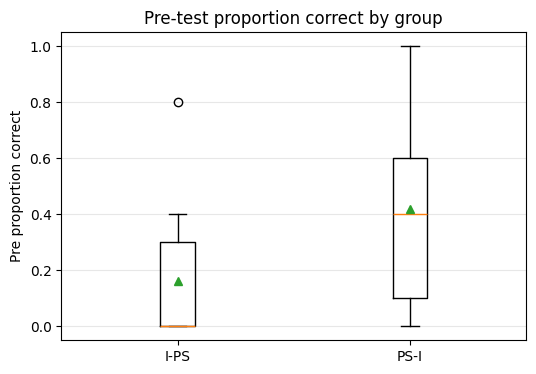

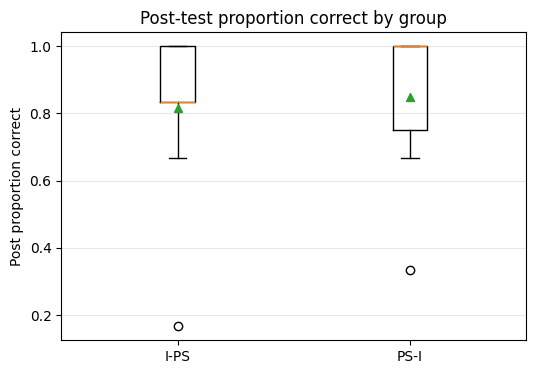

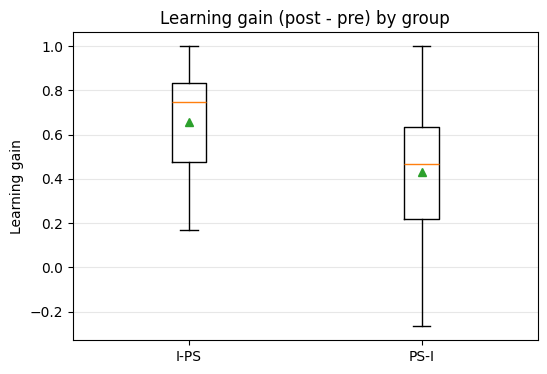

In [80]:
import matplotlib.pyplot as plt

def boxplot_by_group(y_col, title, ylabel):
    groups = ["I-PS", "PS-I"]
    data = [df2.loc[df2["Group"]==g, y_col].dropna().values for g in groups]

    plt.figure(figsize=(6,4))
    plt.boxplot(data, tick_labels=groups, showmeans=True)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(axis="y", alpha=0.3)
    plt.show()

boxplot_by_group("pre_prop", "Pre-test proportion correct by group", "Pre proportion correct")
boxplot_by_group("post_prop", "Post-test proportion correct by group", "Post proportion correct")
boxplot_by_group("learning_gain", "Learning gain (post - pre) by group", "Learning gain")


1) Figure 1 — Pre-test proportion correct by group

- What the plot shows

The PS-I group has a higher median and mean pre-test score than I-PS.

The I-PS distribution is clustered close to 0 with a low median, while PS-I spans a wider range with many participants above 0.2–0.4.

- How to interpret

This suggests a baseline imbalance: participants assigned to PS-I started with higher prior knowledge.

This matters because higher pre-test performance reduces “room to improve,” which can artificially reduce observed learning gain in PS-I (ceiling/room-to-improve issue).

- One sentence you can use

The pre-test distribution indicates PS-I participants entered with higher baseline knowledge than I-PS, which may confound raw gain comparisons because the groups did not start from the same level.

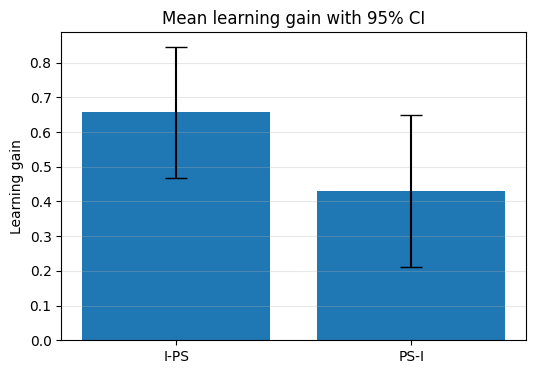

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def mean_ci_plot(y_col, title, ylabel):
    groups = ["I-PS", "PS-I"]
    means, cis = [], []
    for g in groups:
        vals = df2.loc[df2["Group"]==g, y_col].dropna().values
        n = len(vals)
        m = np.mean(vals)
        se = np.std(vals, ddof=1) / np.sqrt(n) if n > 1 else 0.0
        ci95 = 1.96 * se
        means.append(m)
        cis.append(ci95)

    x = np.arange(len(groups))
    plt.figure(figsize=(6,4))
    plt.bar(x, means, yerr=cis, capsize=8)
    plt.xticks(x, groups)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(axis="y", alpha=0.3)
    plt.show()

mean_ci_plot("learning_gain", "Mean learning gain with 95% CI", "Learning gain")


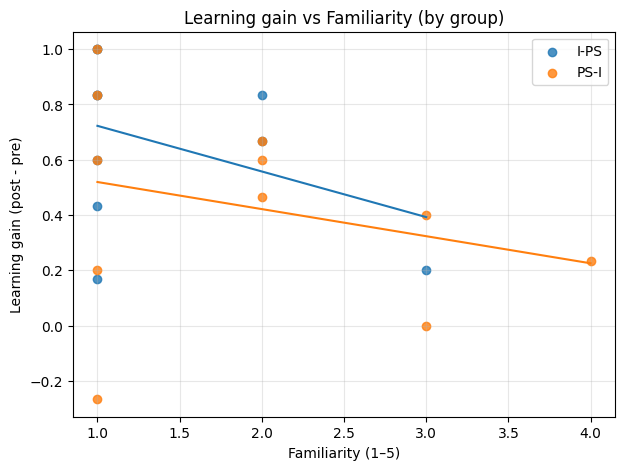

In [82]:
import numpy as np
import matplotlib.pyplot as plt

def moderation_plot():
    plt.figure(figsize=(7,5))

    for g in ["I-PS", "PS-I"]:
        sub = df2[df2["Group"] == g].dropna(subset=["Familiarity","learning_gain"])
        x = sub["Familiarity"].astype(float).values
        y = sub["learning_gain"].astype(float).values

        plt.scatter(x, y, label=g, alpha=0.8)

        # Fit simple line y = a + b*x if enough points
        if len(x) >= 2:
            b, a = np.polyfit(x, y, 1)  # slope, intercept
            xs = np.linspace(min(x), max(x), 50)
            ys = a + b*xs
            plt.plot(xs, ys)

    plt.title("Learning gain vs Familiarity (by group)")
    plt.xlabel("Familiarity (1–5)")
    plt.ylabel("Learning gain (post - pre)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

moderation_plot()


## Mathis

In [5]:
PSI_data['Group'] = 'PSI'
IPS_data['Group'] = 'IPS'

combined_df = pd.concat([PSI_data, IPS_data], ignore_index=True)

correct_answers = {
    # Pre-Activity
    combined_df.columns[5]: "Drawing district lines to favor a specific political party or group.",
    combined_df.columns[6]: "One party could still win more seats if the district boundaries are drawn in a certain way.",
    combined_df.columns[7]: "Random district creation",
    combined_df.columns[8]: "District boundaries were drawn in a way that favors Party Y.",
    combined_df.columns[9]: "Districts have very irregular shapes, and one party wins many more seats than its share of votes.",
    # Post-Activity
    combined_df.columns[10]: "To maximize the number of districts won by their party",
    combined_df.columns[11]: "The fair player attempts to divide the map without any bias, while the partisan player tries to skew it in their favor.",
    combined_df.columns[12]: "Cracking",
    combined_df.columns[13]: "Deliberately designing district boundaries to benefit a particular party or group.",
    combined_df.columns[14]: "It can lead to disproportionate representation for one party.",
    combined_df.columns[15]: "A map with odd-shaped districts that maximize the influence of one party."
}

def calculate_score(row):
    score = 0
    for col, correct in correct_answers.items():
        if row[col] == correct:
            score += 1
    return score

combined_df['Total_Score'] = combined_df.apply(calculate_score, axis=1)


# One-way Anova based on the 2 groups
group_psi_scores = combined_df[combined_df['Group'] == 'PSI']['Total_Score']
group_ips_scores = combined_df[combined_df['Group'] == 'IPS']['Total_Score']

f_stat, p_val = stats.f_oneway(group_psi_scores, group_ips_scores)

print("One-Way ANOVA (PSI vs IPS)")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val < 0.05:
    print("Result: Significant difference between PSI and IPS.")
else:
    print("Result: No significant difference found.")
print("Here a bigger p_value means that there is no significant difference (p>0.5)\n")

# Two-way ANOVA (on familiarity and group)
col_familiarity = combined_df.columns[3] # Index 3 is Familiarity
combined_df = combined_df.rename(columns={col_familiarity: 'Familiarity'})

# Create the model: Score depends on Group + Familiarity
model = ols('Total_Score ~ C(Group) + C(Familiarity)', data=combined_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("Two-Way ANOVA Table")
print(anova_table)
print("Here C(Group) means that there is no significant difference between both groups tested\n")
print("C(Familiarity) being high means that the initial knowledge does play a huge part. Which is logical.\n")
print("F(1,15) = 1.32, p=0.27 and F(3,15) = 3.71, p= 0.035 \n")

One-Way ANOVA (PSI vs IPS)
F-statistic: 1.6698
P-value: 0.2126
Result: No significant difference found.
Here a bigger p_value means that there is no significant difference (p>0.5)

Two-Way ANOVA Table
                   sum_sq    df         F    PR(>F)
C(Group)         5.323867   1.0  1.322476  0.268153
C(Familiarity)  44.806695   3.0  3.710071  0.035382
Residual        60.385224  15.0       NaN       NaN
Here C(Group) means that there is no significant difference between both groups tested

C(Familiarity) being high means that the initial knowledge does play a huge part. Which is logical.

F(1,15) = 1.32, p=0.27 and F(3,15) = 3.71, p= 0.035 

